In [1]:
import requests 
from PIL import Image
from sys import exit
from io import BytesIO
from colorsys import rgb_to_hsv, hsv_to_rgb
from scipy.cluster.vq import kmeans
from numpy import array

In [2]:
DEFAULT_NUM_COLORS = 6
# default minimum and maximum values are used to clamp the color values to a specific range
# originally this was set to 170 and 200, but I'm running with 0 and 256 in order to 
# not clamp the values. This can also be set as a parameter. 
DEFAULT_MINV = 0
DEFAULT_MAXV = 256

THUMB_SIZE = (200, 200)
SCALE = 256.0

def down_scale(x):
    return x / SCALE

def up_scale(x):
    return int(x * SCALE)

def clamp(color, min_v, max_v):
    """
    Clamps a color such that the value (lightness) is between min_v and max_v.
    """
    # use down_scale to convert color to value between 0-1 as expected by rgb_hsv
    h, s, v = rgb_to_hsv(*map(down_scale, color))
    # also convert the min_v and max_v to values between 0-1
    min_v, max_v = map(down_scale, (min_v, max_v))
    # get the maximum of the min value and the color's value (therefore bumping it up if needed)
    # then get the minimum of that number and the max_v (bumping the value down if needed)
    v = min(max(min_v, v), max_v)
    # convert the h, s, v(which has been clamped) to rgb, apply upscale to get it back to 0-255, return tuple R,G,B
    return tuple(map(up_scale, hsv_to_rgb(h, s, v)))

def order_by_hue(colors):
    """
    Orders colors by hue.
    """
    hsvs = [rgb_to_hsv(*map(down_scale, color)) for color in colors]
    hsvs.sort(key=lambda t: t[0])
    return [tuple(map(up_scale, hsv_to_rgb(*hsv))) for hsv in hsvs]

def get_colors(img):
    """
    Returns a list of all the image's colors.
    """
    w, h = img.size
    # convert('RGB') converts the image's pixels info to RGB 
    # getcolors() returns an unsorted list of (count, pixel) values
    # w * h ensures that maxcolors parameter is set so that each pixel could be unique
    # there are three values returned in a list
    return [color for count, color in img.convert('RGB').getcolors(w * h)]

def hexify(rgb):
    return "#{0:02x}{1:02x}{2:02x}".format(*rgb)

def colorz(image_url, n=DEFAULT_NUM_COLORS, min_v=DEFAULT_MINV, max_v=DEFAULT_MAXV,
           order_colors=True):
    """
    Get the n most dominant colors of an image.
    Clamps value to between min_v and max_v.

    Total number of colors returned is n, optionally ordered by hue.
    Returns as a list of RGB triples.

    """
    try:
        r = requests.get(image_url)
    except ValueError:
        print("{0} was not a valid URL.".format(image_file))
        exit(1)
    img = Image.open(BytesIO(r.content))
    img.thumbnail(THUMB_SIZE) # replace with a thumbnail with same aspect ratio, no larger than THUMB_SIZE
    obs = get_colors(img) # gets a list of RGB colors (e.g. (213, 191, 152)) for each pixel
    # adjust the value of each color, if you've chosen to change minimum and maximum values
    clamped = [clamp(color, min_v, max_v) for color in obs] 
    # turns the list of colors into a numpy array of floats, then applies scipy's k-means function
    clusters, _ = kmeans(array(clamped).astype(float), n) 
    colors = order_by_hue(clusters) if order_colors else clusters    
    hex_colors = list(map(hexify, colors)) # turn RGB into hex colors for web
    return hex_colors

In [3]:
single_image = colorz("LINK TO HOSTED IMAGE (i.e. on aws)")
single_image

['#bb9e8c', '#cecbc8', '#af8f64', '#959a9a', '#585962', '#7b7676']

In [4]:
#make a Seaborn palette
%matplotlib inline

In [5]:
import numpy as np
import seaborn as sns

In [6]:
import matplotlib.pyplot as plt

In [7]:
sns.set(rc={"figure.figsize": (6,6)})
np.random.seed(sum(map(ord, "palettes")))

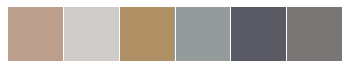

In [8]:
current_palette = sns.color_palette(single_image)
sns.palplot(current_palette)
plt.savefig('NAME_OF_FILE', dpi = 400, bbox_inches='tight', pad_inches=0, transparent=True)